In [7]:
import util
import pandas as pd
import numpy as np
import twsq
from twsq.alpha import Alpha

In [2]:
layer1_coin_names = util.get_layer1_universe()


Fetched page 1 with 250 coins.
Fetched page 2 with 250 coins.
Fetched page 3 with 250 coins.
Fetched page 4 with 3 coins.


In [66]:
class MRZSLong(Alpha):
    def filter_universe(self, universe, window_needed, freq='30m'):
        """
        Filter the provided universe to include only symbols for which data exists.

        Parameters:
        -----------
        universe : list
            List of asset symbols.
        window_needed : int
            Minimum number of bars required.
        freq : str, optional
            Frequency of the bars (default '1h').

        Returns:
        --------
        list
            Filtered list of symbols.
        """
        valid_symbols = []
        for symbol in universe:
            try:
                bars = self.get_lastn_bars(symbol + '/USD', n=window_needed, freq=freq)
                volume = bars['volume'].iloc[-window_needed:].mean()
                price = bars['close'].iloc[-window_needed:].mean()
                trading_volume = volume * price
                if not bars.empty and len(bars) >= window_needed and trading_volume > 100:
                    valid_symbols.append(symbol)
            except Exception as e:
                continue
        return valid_symbols
    """
    Mean reversion breakout strategy for short positions.
    """

    def prepare(self, universe=None, enter_zscore = -3, exit_zscore = 1, enter_lookback=24, exit_lookback=30, dollar_exposure=100, freq = '30m'):
        """
        Initialize strategy parameters.
        Parameters:
        -----------
        universe : list
            List of asset symbols to consider (e.g. ['BTC/USD', 'ETH/USD']).
        enter_lookback : int, optional
            Lookback period for the entry threshold.
        exit_lookback : int, optional
            Lookback period for the exit threshold.
        dollar_exposure : float, optional
            Total dollar exposure.
        """
        if universe is None:
            universe = util.get_layer1_universe()
        universe = [str(symbol).upper() for symbol in universe]
        self.enter_lookback = enter_lookback
        self.exit_lookback = exit_lookback
        self.dollar_exposure = dollar_exposure
        self.enter_zscore = enter_zscore
        self.exit_zscore = exit_zscore
        window_needed = max(self.enter_lookback, self.exit_lookback)
        self.universe = self.filter_universe(universe, window_needed, freq=freq)
        self.current_signals = {symbol: 0 for symbol in universe}
    
    def rebalance(self):
        """
        Compute mr breakout signals and rebalance positions.
        Dollar exposure is total exposure across all short positions.
        """
        self.cancel_all_orders()
        signals = {}
        # Determine the number of bars needed from history.
        window_needed = max(self.enter_lookback, self.exit_lookback)
        
        # Compute signals for each asset.
        for symbol in self.universe:
            try:
                bars = self.get_lastn_bars(symbol + "/USDT", n=window_needed, freq=self.freq)
                # Check if we have enough data.
                if bars.empty:
                    signal = 0
                else:
                    price_series = bars
                    ret = price_series['close'].pct_change()
                    current_ret = ret.iloc[-1]
                    enter_std = ret.iloc[-self.enter_lookback:].std()
                    exit_std = ret.iloc[-self.exit_lookback:].std()
                    if enter_std == 0 or exit_std == 0:
                        signal = 0
                        continue
                    enter_zscore = (current_ret - ret.iloc[-self.enter_lookback:].mean()) / ret.iloc[-self.enter_lookback:].std()
                    exit_zscore = (current_ret- ret.iloc[-self.exit_lookback:].mean()) / ret.iloc[-self.exit_lookback:].std()
                    # enter_max = price_series['close'].rolling(window=self.enter_lookback, min_periods = 1).max().iloc[-1]
                    # exit_min = price_series['close'].rolling(window=self.exit_lookback, min_periods = 1).min().iloc[-1]
                    
                    # Determine signal based on the most recent value.
                    if not price_series.empty:
                        if enter_zscore < self.enter_zscore:
                            signal = 1  # Enter short
                        elif exit_zscore > self.exit_zscore:
                            signal = 0   # Exit short
                        else:
                            signal = self.current_signals[symbol]
                    else:
                        signal = 0
            except Exception as e:
                print(f"Error processing {symbol}: {e}")
                signal = 0
            self.current_signals[symbol] = signal
            signals[symbol] = signal
        longs = [symbol for symbol, sig in signals.items() if sig == 1]
        nlong = len(longs)
        positions = self.get_pos()
        for symbol, signal in signals.items():
            try:
                price = self.get_current_price(symbol + '/USDT')
                current_pos = positions.get(symbol, 0)
            except Exception as e:
                continue
            if signal == 1 and nlong > 0:
                trd = (self.dollar_exposure / nlong) / price - current_pos
                try:
                    if trd > 0:
                        self.create_order(
                            symbol+"/USDT",
                            trd,
                            'buy',
                            price
                        )
                    elif trd == 0:
                        continue
                    else:
                        self.create_order(
                            symbol + "/USDT",
                            abs(trd),
                            'sell',
                            price,
                        )
                except Exception as e:
                    print(f"Error creating order for {symbol}: {e}")
                    continue
            else:
                if current_pos > 0:
                    self.create_order(
                        symbol + "/USDT",
                        current_pos,
                        'sell',
                        price,
                        route='True'
                    )
        self.route()
            

In [67]:
result = MRZSLong.run_backtest(start_ts='20250210', universe = layer1_coin_names, freq='30m', taker_fee = 0.004)

Running MRZSLong backtest: 100.00% done | Total PnL (USDT): 37 | Duration (s): 27  

In [ ]:
MRZSLong.run_live(freq='1h', universe = layer1_coin_names)

26-Feb-25 07:57:09: INFO: 🌱 Live trader initiated
26-Feb-25 07:57:11: INFO: Websocket connected
26-Feb-25 07:57:11: INFO: MRZSLong: Initial positions: None
26-Feb-25 07:57:12: INFO: Websocket connected


<Axes: xlabel='Date'>

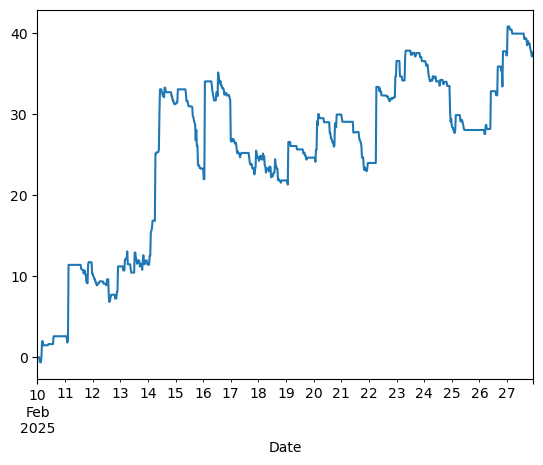

In [65]:
result.pos_pnl['port_val'].plot()

In [60]:
result.pos_pnl[result.pos_pnl['pnl'] < 0].sort_values(by='pnl', ascending=True)

,port_val,pnl,VET,USDT,GRT,EGLD,POLYX,ROSE,BTC,ETH,...,GALA,IOTA,FTM,ETC,ONE,ATOM,BNB,DOT,NEAR,LTC
Date,,,,,,,,,,,,,,,,,,,,,
2025-02-17 00:00:00,26.686996,-5.072329,0.000000,-73.313004,180.766450,1.129178,141.562854,0.000000,0.000260,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2025-02-24 22:30:00,30.549316,-2.933999,0.000000,-69.450684,0.000000,0.799744,102.627258,0.000000,0.000000,0.006439,...,877.192982,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.143246
2025-02-15 19:30:00,23.681392,-2.418193,0.000000,-76.318608,0.000000,0.000000,275.027503,1165.229550,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2025-02-12 14:00:00,7.428012,-2.195460,173.611111,-125.905321,0.000000,0.252640,190.476190,121.859082,0.000058,0.002140,...,250.475904,24.923982,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2025-02-26 20:00:00,33.406534,-1.963111,0.000000,-166.593466,0.000000,0.000000,625.000000,2767.017156,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-11 15:00:00,10.805520,-0.009836,0.000000,-89.194480,0.000000,0.000000,184.774575,0.000000,0.000344,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2025-02-24 06:00:00,34.123307,-0.009112,0.000000,-65.876693,191.277735,1.136364,149.521531,620.809536,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
2025-02-12 03:00:00,9.209459,-0.007011,0.000000,-90.790541,0.000000,1.485443,190.476190,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [61]:
ret = result.pos_pnl['pnl']/1000
ret.mean()/ret.std()*np.sqrt(365*24)

4.385947243949893

<Axes: xlabel='Date'>

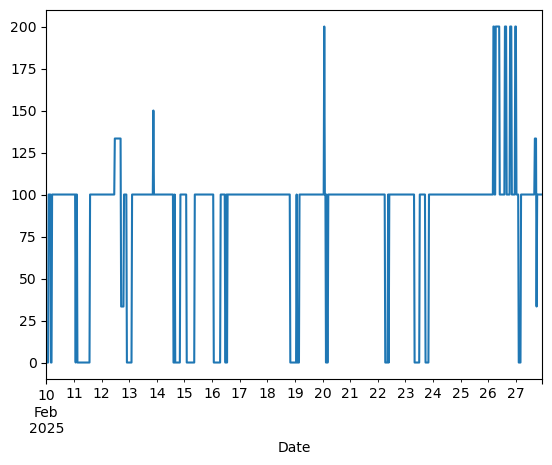

In [62]:
(result.pos_pnl['port_val']-result.pos_pnl['USDT']).plot()

In [ ]:
resul